In [3]:
import matplotlib.pyplot as plt
import numpy as np
import open3d as o3d
from scipy.stats import multivariate_normal
from typing import Tuple, List
import pandas as pd
import os

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [4]:
## Ensure for preventing future error: Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
class Pose3D:
    """
    Pose class for 3D
    """
    def __init__(self, x: float, y: float, z: float, roll: float, pitch: float, yaw: float):
        """
        Constructor of the class
        Args:
            x (float): X offset of the pose
            y (float): Y offset of the pose
            z (float): Z offset of the pose
            roll (float): Roll angle of the pose
            pitch (float): Pitch angle of the pose
            yaw (float): Yaw angle of the pose
        """
        self.x = self._ensure_scalar(x)
        self.y = self._ensure_scalar(y)
        self.z = self._ensure_scalar(z)
        self.roll = self._ensure_scalar(roll)
        self.pitch = self._ensure_scalar(pitch)
        self.yaw = self._ensure_scalar(yaw)
    
    def _ensure_scalar(self, value) -> float:
        """
        Ensure the value is a scalar float
        Args:
            value: The input value which can be a scalar or an array
        Returns:
            float: Scalar float value
        """
        if np.isscalar(value):
            return float(value)
        else:
            return float(value.item())
    
    def get_transformation(self) -> Tuple[np.ndarray, np.ndarray]:
        """
        Method to obtain the Rotation matrix and translation vector of a given pose.
        Returns:
            Tuple[np.ndarray, np.ndarray]: Rotation as a 3x3 matrix
                                           translation vector as 3x1 matrix
        """
        x = self.x
        y = self.y
        z = self.z
        roll = self.roll
        pitch = self.pitch
        yaw = self.yaw
        
        Rx = np.array([[1, 0, 0],
                       [0, np.cos(roll), -np.sin(roll)],
                       [0, np.sin(roll), np.cos(roll)]])
        
        Ry = np.array([[np.cos(pitch), 0, np.sin(pitch)],
                       [0, 1, 0],
                       [-np.sin(pitch), 0, np.cos(pitch)]])
        
        Rz = np.array([[np.cos(yaw), -np.sin(yaw), 0],
                       [np.sin(yaw), np.cos(yaw), 0],
                       [0, 0, 1]])
        
        R = Rz @ Ry @ Rx
        t = np.array([[x], [y], [z]])
        
        return R, t

    def __add__(self, other):
        """
        Addition method
        Args:
            other (Pose3D): Pose to add
        Returns:
            Pose3D: new pose that represents the addition
                  of two poses.
        """
        x = self.x + other.x
        y = self.y + other.y
        z = self.z + other.z
        roll = self.roll + other.roll
        pitch = self.pitch + other.pitch
        yaw = self.yaw + other.yaw
        return Pose3D(x, y, z, roll, pitch, yaw)

In [5]:
def _ensure_scalar(self, value) -> float:
    """
    Ensure the value is a scalar float
    Args:
        value: The input value which can be a scalar or an array
    Returns:
        float: Scalar float value
    """
    if np.isscalar(value):
        return float(value)
    else:
        return float(value.item())

In [6]:
class NDT3D:
    """
    NDT3D class for 3D NDT (Normal Distributions Transform).
    """
    def __init__(self, cell_size_x: float, cell_size_y: float, cell_size_z: float):
        """
        Constructor of the class.
        Args:
            cell_size_x (float): Size of the cell in the x direction.
            cell_size_y (float): Size of the cell in the y direction.
            cell_size_z (float): Size of the cell in the z direction.
        """
        self.cell_size_x = cell_size_x
        self.cell_size_y = cell_size_y
        self.cell_size_z = cell_size_z
        self.grid = {}
    
    def set_input_cloud(self, point_cloud: np.ndarray):
        """
        Set the input cloud to populate the NDT grid.
        Args:
            point_cloud (np.ndarray): Input point cloud as N x 3 numpy array.
        """
        if not isinstance(point_cloud, np.ndarray) or point_cloud.shape[1] != 3:
            raise ValueError("point_cloud must be a numpy array with shape (N, 3)")
        
        for point in point_cloud:
            cell_idx = (int(point[0] // self.cell_size_x), 
                        int(point[1] // self.cell_size_y), 
                        int(point[2] // self.cell_size_z))
            if cell_idx not in self.grid:
                self.grid[cell_idx] = []
            self.grid[cell_idx].append(point)
        self._compute_gaussians()
    
    def _compute_gaussians(self):
        """
        Compute the Gaussian distributions for each cell in the grid.
        """
        self.gaussians = {}
        for cell_idx, points in self.grid.items():
            points = np.array(points)
            if len(points) >= 3:  # We need at least 3 points to define a Gaussian in 3D
                mean = np.mean(points, axis=0)
                cov = np.cov(points, rowvar=False)
                # Regularize the covariance matrix if necessary
                cov += np.eye(cov.shape[0]) * 1e-6  # Adding a small value to the diagonal
                self.gaussians[cell_idx] = (mean, cov)
    
    def calculate_score(self, transformed_scan: np.ndarray) -> float:
        """
        Calculate the NDT score for a given transformed scan.
        Args:
            transformed_scan (np.ndarray): Transformed scan as N x 3 numpy array.
        Returns:
            float: NDT score.
        """
        if not isinstance(transformed_scan, np.ndarray) or transformed_scan.shape[1] != 3:
            raise ValueError("transformed_scan must be a numpy array with shape (N, 3)")
        
        score = 0
        for point in transformed_scan:
            cell_idx = (int(point[0] // self.cell_size_x), 
                        int(point[1] // self.cell_size_y), 
                        int(point[2] // self.cell_size_z))
            if cell_idx in self.gaussians:
                mean, cov = self.gaussians[cell_idx]
                try:
                    mvn = multivariate_normal(mean=mean, cov=cov, allow_singular=True)
                    score += mvn.logpdf(point)
                except np.linalg.LinAlgError:
                    continue  # Skip this point if there's an error with the covariance matrix
        return score
    
    def align(self, source_cloud: np.ndarray, init_pose: Pose3D, max_iter: int) -> Tuple[Pose3D, List[Pose3D]]:
        """
        Align the source cloud to the target cloud using NDT.
        Args:
            source_cloud (np.ndarray): Source point cloud as N x 3 numpy array.
            init_pose (Pose3D): Initial pose guess.
            max_iter (int): Maximum number of iterations.
        Returns:
            Tuple[Pose3D, List[Pose3D]]: Final pose and list of poses for each iteration.
        """
        if not isinstance(source_cloud, np.ndarray) or source_cloud.shape[1] != 3:
            raise ValueError("source_cloud must be a numpy array with shape (N, 3)")
        
        pose = init_pose
        cache_list = [pose]
        for _ in range(max_iter):
            R, t = pose.get_transformation()
            transformed_scan = (R @ source_cloud.T + t).T
            score = self.calculate_score(transformed_scan)
            
            # Compute gradients
            grad = np.zeros((6, 1))
            for point in source_cloud:
                cell_idx = (int(point[0] // self.cell_size_x), 
                            int(point[1] // self.cell_size_y), 
                            int(point[2] // self.cell_size_z))
                if cell_idx in self.gaussians:
                    mean, cov = self.gaussians[cell_idx]
                    mvn = multivariate_normal(mean=mean, cov=cov, allow_singular=True)
                    weight = mvn.pdf(point)
                    diff = (point - mean).reshape((3, 1))
                    grad[0:3] += weight * diff
                    grad[3:6] += weight * (R.T @ diff)
            
            # Update pose
            alpha = self.compute_step_length(pose, grad, source_cloud)
            delta_pose = (alpha * grad).flatten()
            pose += Pose3D(delta_pose[0], delta_pose[1], delta_pose[2],
                           delta_pose[3], delta_pose[4], delta_pose[5])
            cache_list.append(pose)
        return pose, cache_list
    
    def compute_step_length(self, pose: Pose3D, grad: np.ndarray, source_cloud: np.ndarray) -> float:
        """
        Compute the step length for the gradient descent.
        Args:
            pose (Pose3D): Current pose.
            grad (np.ndarray): Gradient.
            source_cloud (np.ndarray): Source point cloud.
        Returns:
            float: Step length.
        """
        alpha = 1.0
        best_alpha = 0
        curr_score = -np.inf
        for _ in range(10):
            T = grad * alpha
            new_pose = pose + Pose3D(T[0], T[1], T[2], T[3], T[4], T[5])
            R, t = new_pose.get_transformation()
            transformed_scan = (R @ source_cloud.T + t).T
            score = self.calculate_score(transformed_scan)
            if score > curr_score:
                best_alpha = alpha
                curr_score = score
            alpha *= 0.7
        return best_alpha

# Utility Functions 

In [7]:
# Load map point cloud --> map.pcd 
def load_point_cloud(file_path: str) -> np.ndarray:
    pcd = o3d.io.read_point_cloud(file_path)
    return np.asarray(pcd.points)

def generate_synthetic_point_cloud(num_points=100):
    return np.random.rand(num_points, 3) * 10

In [8]:
# Data Initialization
map_pcd = generate_synthetic_point_cloud(1000)
frame_pcd_list = [generate_synthetic_point_cloud() for _ in range(5)]
init_pose_3d = Pose3D(1, 1, 1, 0.1, 0.1, 0.1)
ndt_3d = NDT3D(2, 2, 2)
ndt_3d.set_input_cloud(map_pcd)

In [9]:
# Vizualization Function 
def visualize_ndt_3d_results(source, ndt, pose, cache_list):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(source[:, 0], source[:, 1], source[:, 2], c='r', marker='o', label='Source')
    target = np.concatenate([np.array(points) for points in ndt.grid.values()])
    ax.scatter(target[:, 0], target[:, 1], target[:, 2], c='b', marker='^', label='Target')
    R, t = pose.get_transformation()
    transformed_scan = (R @ source.T + t).T
    ax.scatter(transformed_scan[:, 0], transformed_scan[:, 1], transformed_scan[:, 2], c='g', marker='x', label='Transformed Source')
    ax.legend()
    plt.show()


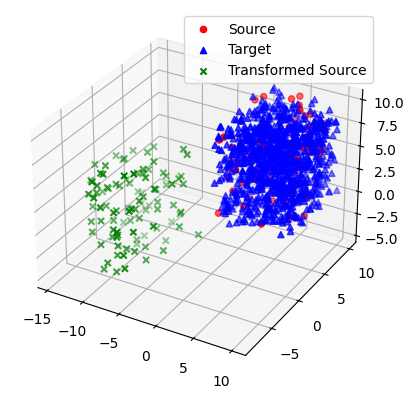

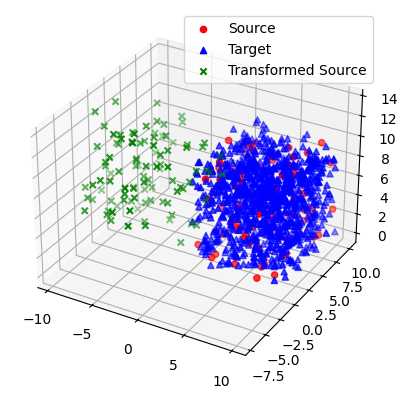

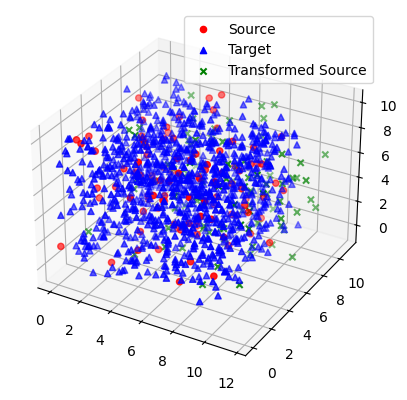

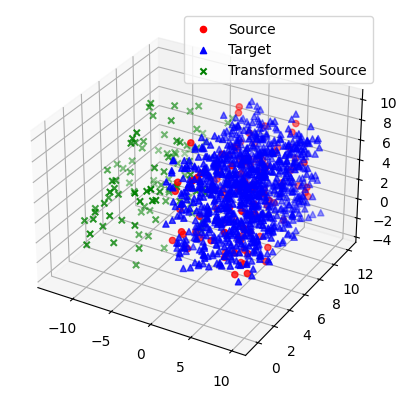

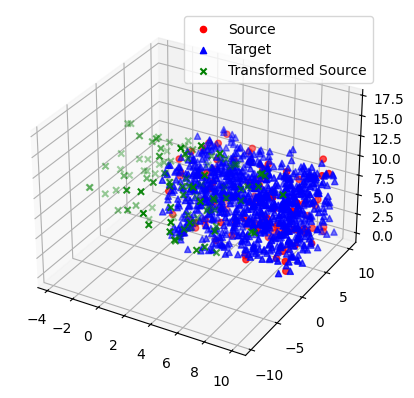

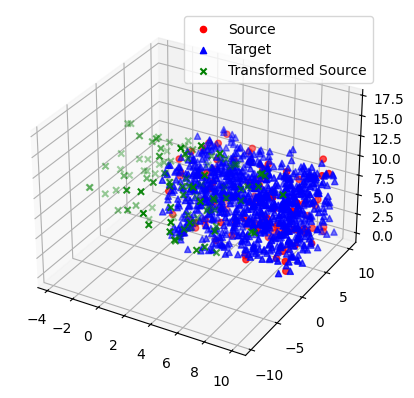

In [10]:
# Frame processing and viz
for frame_pcd in frame_pcd_list:
    pose_3d, cache_list_3d = ndt_3d.align(frame_pcd, init_pose_3d, 10)
    visualize_ndt_3d_results(frame_pcd, ndt_3d, pose_3d, cache_list_3d)

if frame_pcd_list:
    frame_pcd = frame_pcd_list[-1]
    visualize_ndt_3d_results(frame_pcd, ndt_3d, pose_3d, cache_list_3d)


In [11]:
# Utilize real given data
map_pcd_dir = "C:/Users/Soheil/Desktop/pro3/dataset/map.pcd"
sample_frame_pcd_dir = "C:/Users/Soheil/Desktop/pro3/dataset/frames/frame_0.pcd"
ground_truth_dir = "C:/Users/Soheil/Desktop/pro3/dataset/ground_truth.csv"
frame_dir = "C:/Users/Soheil/Desktop/pro3/dataset/frames"

In [12]:
# Load map point cloud
map_pcd = load_point_cloud(map_pcd_dir)
print(type(map_pcd))

<class 'numpy.ndarray'>


In [13]:
# Load ground_truth 
ground_truth = pd.read_csv(ground_truth_dir)
print(ground_truth.head())

   Frame    x    y         z   roll   pitch   yaw
0      0  0.0  0.0  0.000000    0.0     0.0   0.0
1      1  0.0  0.0  0.015636    0.0     0.0   0.0
2      2  0.0  0.0  0.005846    0.0     0.0   0.0
3      3  0.0  0.0  0.005628    0.0     0.0   0.0
4      4  0.0  0.0  0.005628    0.0     0.0   0.0


In [20]:


def ndt_registration(source, target, init_transformation):
    threshold = 1.0  # Set the distance threshold for the registration
    reg_p2p = o3d.pipelines.registration.registration_icp(
        source, target, threshold, init_transformation,
        o3d.pipelines.registration.TransformationEstimationPointToPlane())
    return reg_p2p


In [23]:
# Define the ndt_registration function
def ndt_registration(source, target, init_transformation):
    threshold = 1.0  # Set the distance threshold for the registration
    
    # Compute normal vectors for the target point cloud
    target.estimate_normals()
    
    # Perform NDT registration
    reg_p2p = o3d.pipelines.registration.registration_icp(
        source, target, threshold, init_transformation,
        o3d.pipelines.registration.TransformationEstimationPointToPlane())
    
    return reg_p2p

# Directory containing the frame.pcd files
frame_dir = frame_dir

# Initial pose
current_pose = np.eye(4)

# List to store the estimated poses
estimated_poses = []

# Load the map point cloud (assuming map_pcd is already loaded)
map_pcd = o3d.io.read_point_cloud(map_pcd_dir)
map_pcd.estimate_normals()

# Iterate over all frames
for frame_file in sorted(os.listdir(frame_dir)):
    frame_path = os.path.join(frame_dir, frame_file)
    frame_pcd = o3d.io.read_point_cloud(frame_path)
    
    # Perform NDT registration
    result = ndt_registration(frame_pcd, map_pcd, current_pose)
    
    # Update current pose
    current_pose = np.dot(current_pose, result.transformation)
    
    # Append the current pose to the list of estimated poses
    estimated_poses.append(current_pose)

    print(f"Processed {frame_file}")


Processed frame_0.pcd
Processed frame_1.pcd
Processed frame_10.pcd
Processed frame_100.pcd
Processed frame_1000.pcd
Processed frame_1001.pcd
Processed frame_1002.pcd
Processed frame_1003.pcd
Processed frame_1004.pcd
Processed frame_1005.pcd
Processed frame_1006.pcd
Processed frame_1007.pcd
Processed frame_1008.pcd
Processed frame_1009.pcd
Processed frame_101.pcd
Processed frame_1010.pcd
Processed frame_1011.pcd
Processed frame_1012.pcd
Processed frame_1013.pcd
Processed frame_102.pcd
Processed frame_103.pcd
Processed frame_104.pcd
Processed frame_105.pcd
Processed frame_106.pcd
Processed frame_107.pcd
Processed frame_108.pcd
Processed frame_109.pcd
Processed frame_11.pcd
Processed frame_110.pcd
Processed frame_111.pcd
Processed frame_112.pcd
Processed frame_113.pcd
Processed frame_114.pcd
Processed frame_115.pcd
Processed frame_116.pcd
Processed frame_117.pcd
Processed frame_118.pcd
Processed frame_119.pcd
Processed frame_12.pcd
Processed frame_120.pcd
Processed frame_121.pcd
Processed

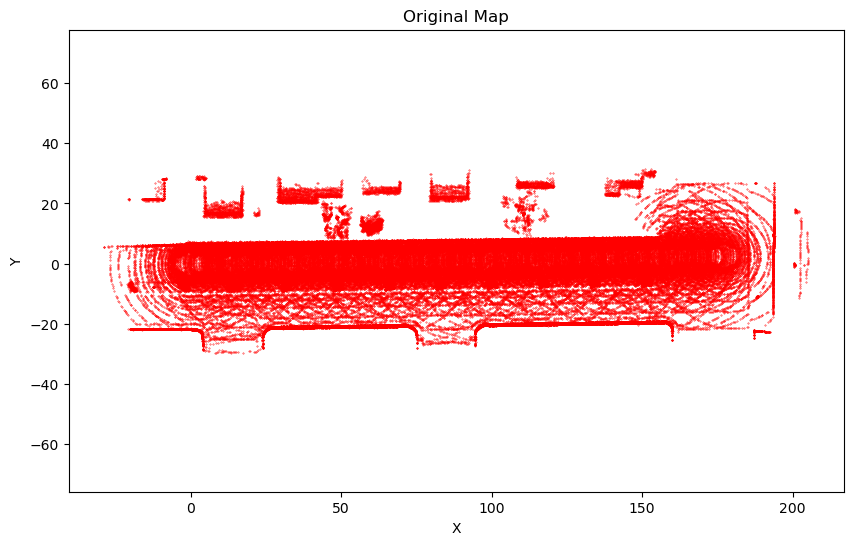

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import open3d as o3d

# Function to load point clouds from .pcd files
def load_point_cloud(file_path: str) -> np.ndarray:
    pcd = o3d.io.read_point_cloud(file_path)
    return np.asarray(pcd.points)

# Load the map point cloud
map_pcd = load_point_cloud("/Users/memento/Downloads/dataset/map.pcd")  

# Project the 3D points onto a 2D plane (e.g., X-Y plane)
x = map_pcd[:, 0]
y = map_pcd[:, 1]
z = map_pcd[:, 2]

# Create a 2D plot of the projected points
plt.figure(figsize=(10, 6))
plt.scatter(x, y, c='red', s=0.1)
plt.title('Original Map')
plt.xlabel('X')
plt.ylabel('Y')
plt.axis('equal')
plt.show()


Loading map point cloud...
Loaded map point cloud in 0.09 seconds
Loading frame point clouds...
Loaded frame point clouds in 0.03 seconds
Setting input cloud for NDT...
Set input cloud in 0.16 seconds
Processing frames...


/var/folders/dv/0fvvb0j52ss7zk3yjrvjzhd00000gn/T/ipykernel_81384/580759890.py:13: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  self.x = float(x)
/var/folders/dv/0fvvb0j52ss7zk3yjrvjzhd00000gn/T/ipykernel_81384/580759890.py:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  self.y = float(y)
/var/folders/dv/0fvvb0j52ss7zk3yjrvjzhd00000gn/T/ipykernel_81384/580759890.py:15: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  self.z = float(z)
/var/folders/dv/0fvvb0j52ss7zk3

Iteration 1/10, score: -inf, pose: -19.454782145773653, -21.856097006980573, 42.314335836072225, -26.545869293426566, -16.618072707384208, 40.82072350962799
Iteration 1/10, score: -inf, pose: -30.27018562438145, -35.249535748306506, 54.38551527249074, -39.78901861234274, -27.7251739555825, 52.79243285658878
Iteration 1/10, score: -inf, pose: -60.24050432706599, -51.50264694684975, 51.0867062142521, -70.74579779098727, -41.4802748501092, 47.71889461967416
Iteration 1/10, score: -inf, pose: -59.23918365169469, -13.272134686691748, 88.34561114561505, -69.67652562596365, 0.018809729540496437, 81.29691337512682
Iteration 1/10, score: -inf, pose: -10.936482429022362, -33.31490760969574, 45.0883006348624, -19.527660509435304, -28.460214594414083, 45.51849661930358
Iteration 2/10, score: 0, pose: -39.909564291547305, -44.712194013961145, 83.62867167214445, -71.43599748816636, -3.5182952808438177, 62.290373032483636
Iteration 2/10, score: 0, pose: -121.48100865413198, -104.0052938936995, 101.17

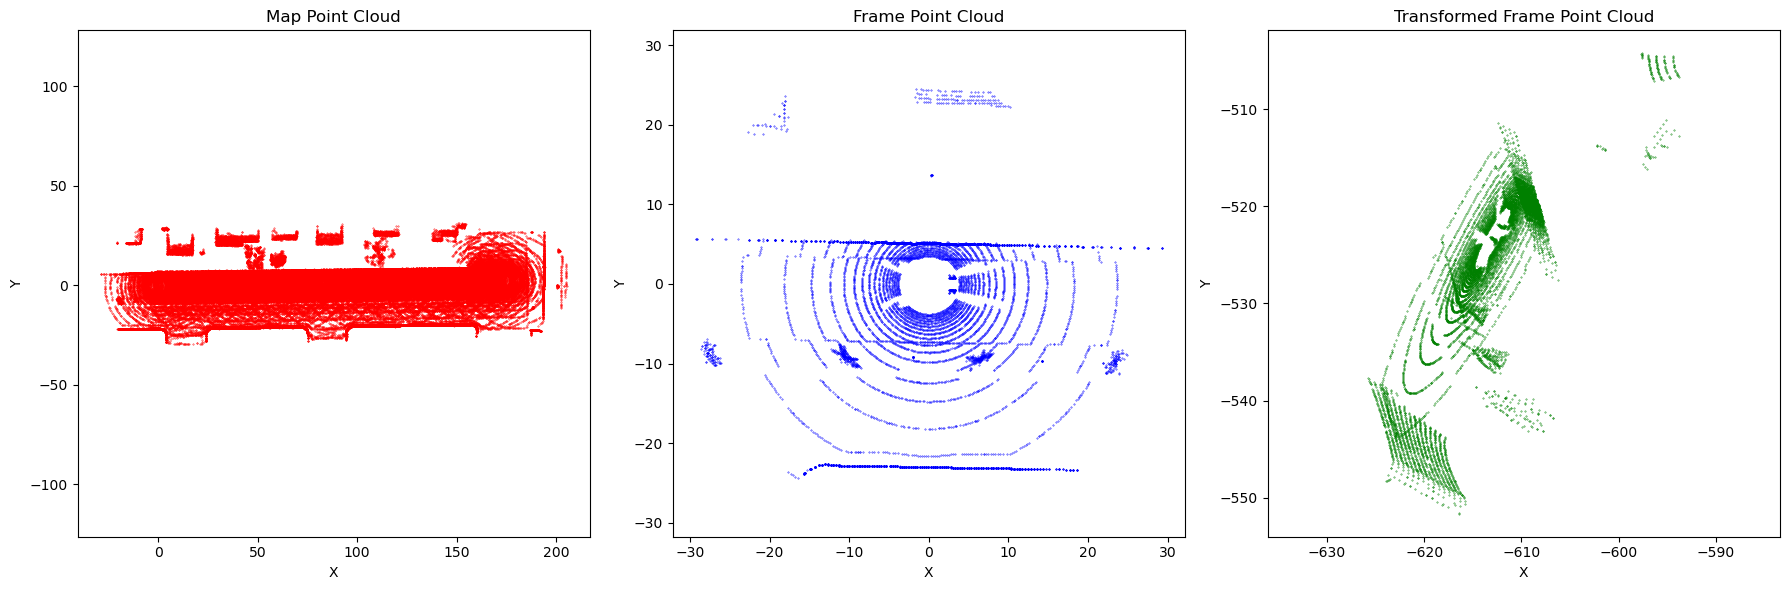

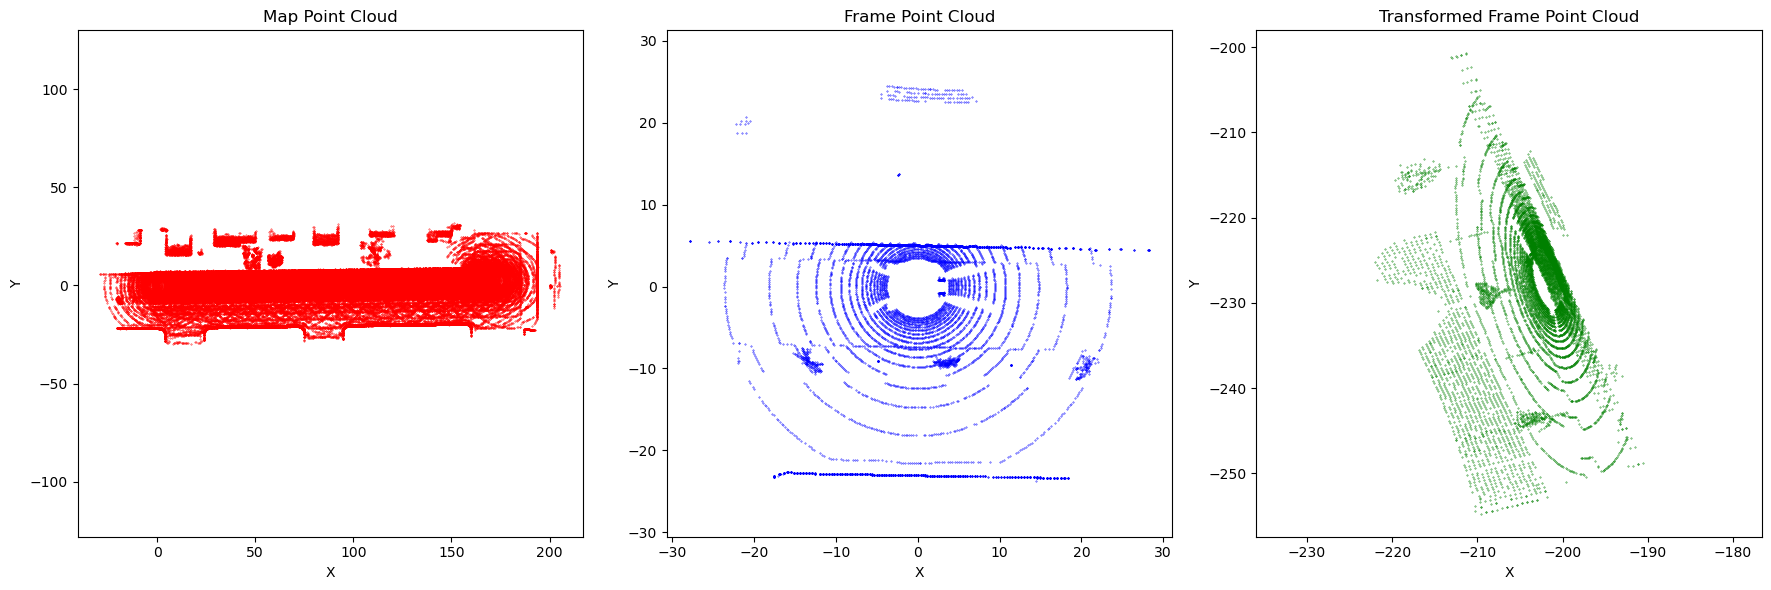

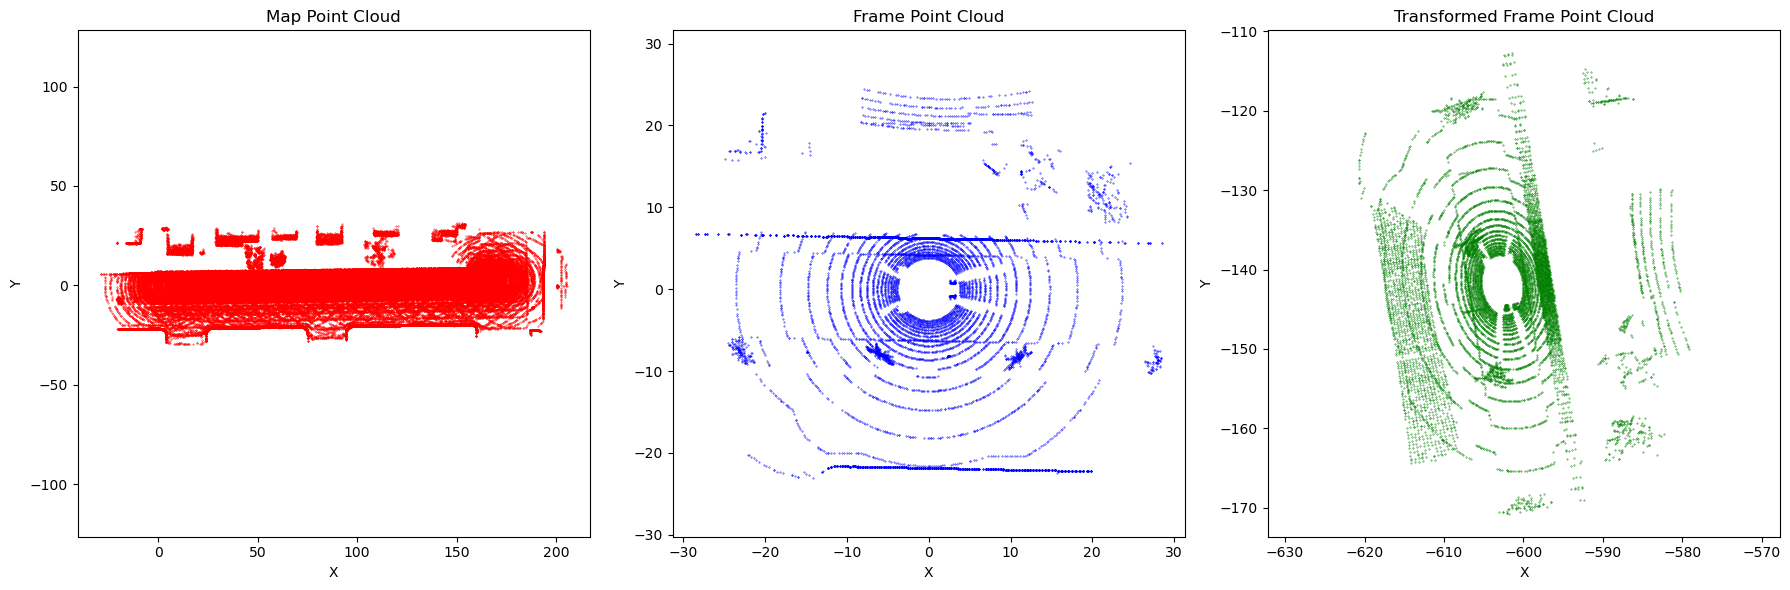

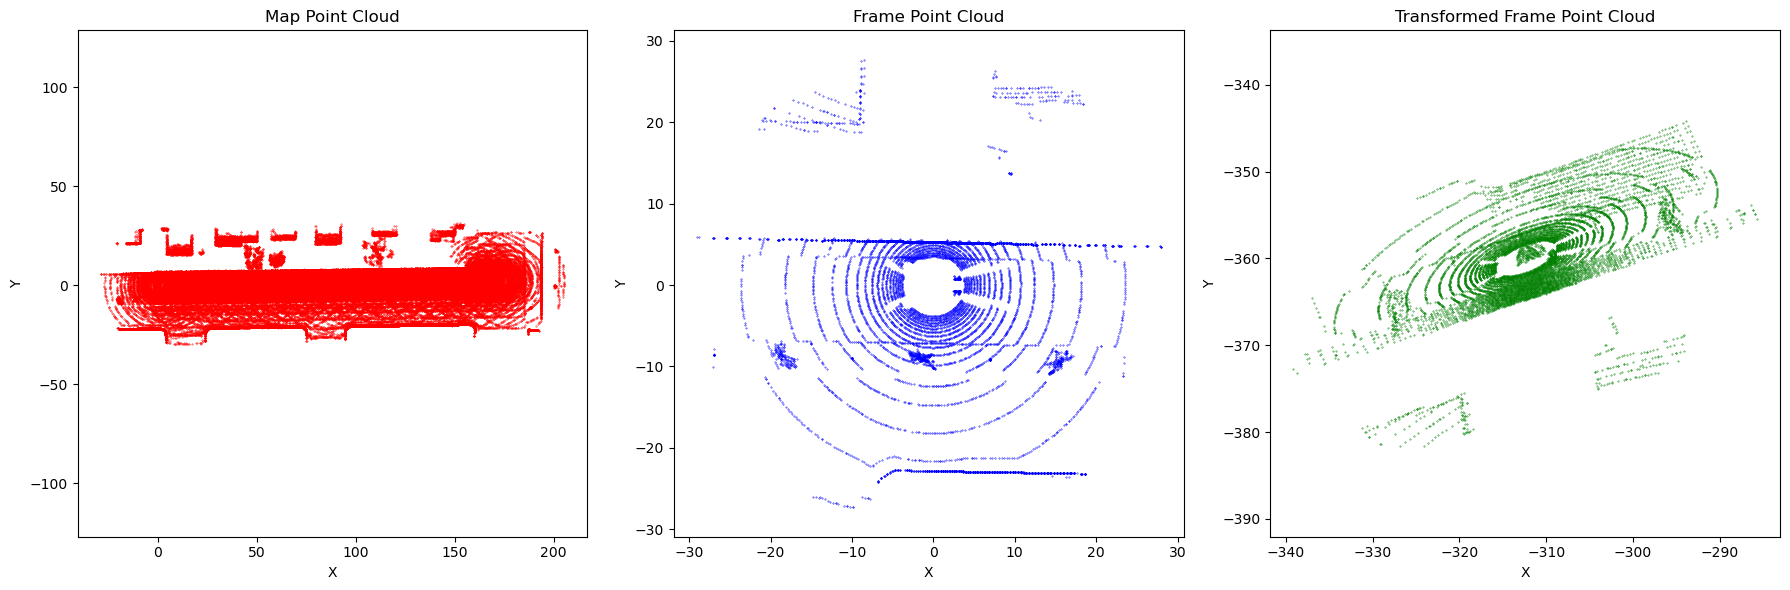

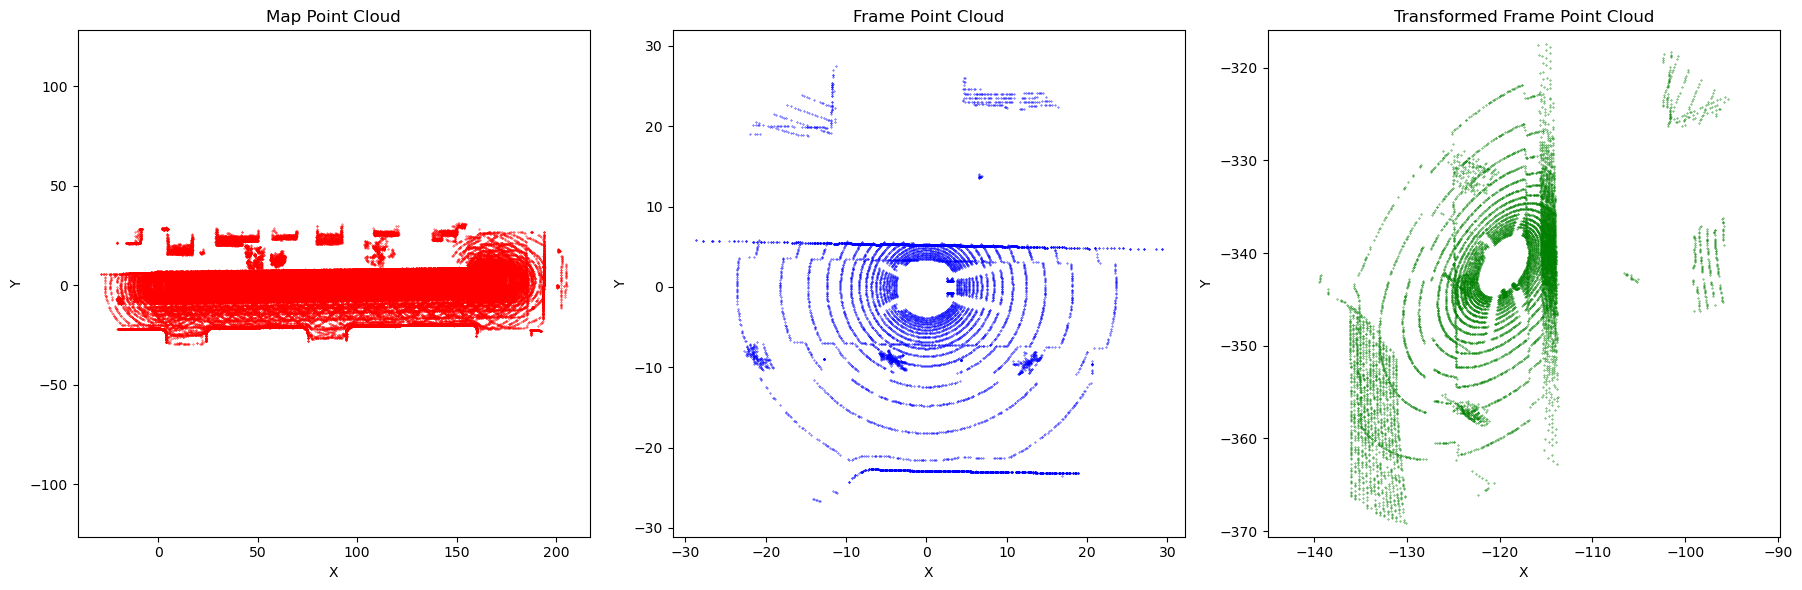

In [6]:
import matplotlib.pyplot as plt
import numpy as np
import open3d as o3d
from scipy.stats import multivariate_normal
from typing import Tuple, List
import glob
import os
from concurrent.futures import ThreadPoolExecutor
import time

class Pose3D:
    def __init__(self, x: float, y: float, z: float, roll: float, pitch: float, yaw: float):
        self.x = float(x)
        self.y = float(y)
        self.z = float(z)
        self.roll = float(roll)
        self.pitch = float(pitch)
        self.yaw = float(yaw)
    
    def get_transformation(self) -> Tuple[np.ndarray, np.ndarray]:
        x, y, z = self.x, self.y, self.z
        roll, pitch, yaw = self.roll, self.pitch, self.yaw
        
        Rx = np.array([[1, 0, 0],
                       [0, np.cos(roll), -np.sin(roll)],
                       [0, np.sin(roll), np.cos(roll)]])
        
        Ry = np.array([[np.cos(pitch), 0, np.sin(pitch)],
                       [0, 1, 0],
                       [-np.sin(pitch), 0, np.cos(pitch)]])
        
        Rz = np.array([[np.cos(yaw), -np.sin(yaw), 0],
                       [np.sin(yaw), np.cos(yaw), 0],
                       [0, 0, 1]])
        
        R = Rz @ Ry @ Rx
        t = np.array([[x], [y], [z]])
        
        return R, t

    def __add__(self, other):
        x = self.x + other.x
        y = self.y + other.y
        z = self.z + other.z
        roll = self.roll + other.roll
        pitch = self.pitch + other.pitch
        yaw = self.yaw + other.yaw
        return Pose3D(x, y, z, roll, pitch, yaw)

class NDT3D:
    def __init__(self, cell_size_x: float, cell_size_y: float, cell_size_z: float):
        self.cell_size_x = cell_size_x
        self.cell_size_y = cell_size_y
        self.cell_size_z = cell_size_z
        self.grid = {}
    
    def set_input_cloud(self, point_cloud: np.ndarray):
        for point in point_cloud:
            cell_idx = (int(point[0] // self.cell_size_x), 
                        int(point[1] // self.cell_size_y), 
                        int(point[2] // self.cell_size_z))
            if cell_idx not in self.grid:
                self.grid[cell_idx] = []
            self.grid[cell_idx].append(point)
        self._compute_gaussians()
    
    def _compute_gaussians(self):
        self.gaussians = {}
        for cell_idx, points in self.grid.items():
            points = np.array(points)
            if len(points) >= 3:
                mean = np.mean(points, axis=0)
                cov = np.cov(points, rowvar=False)
                self.gaussians[cell_idx] = (mean, cov)
    
    def calculate_score(self, transformed_scan: np.ndarray) -> float:
        score = 0
        for point in transformed_scan:
            cell_idx = (int(point[0] // self.cell_size_x), 
                        int(point[1] // self.cell_size_y), 
                        int(point[2] // self.cell_size_z))
            if cell_idx in self.gaussians:
                mean, cov = self.gaussians[cell_idx]
                mvn = multivariate_normal(mean=mean, cov=cov, allow_singular=True)
                score += mvn.logpdf(point)
        return score
    
    def align(self, source_cloud: np.ndarray, init_pose: Pose3D, max_iter: int) -> Tuple[Pose3D, List[Pose3D]]:
        pose = init_pose
        cache_list = [pose]
        for i in range(max_iter):
            R, t = pose.get_transformation()
            transformed_scan = (R @ source_cloud.T + t).T
            score = self.calculate_score(transformed_scan)
            
            grad = np.zeros((6, 1))
            for point in source_cloud:
                cell_idx = (int(point[0] // self.cell_size_x), 
                            int(point[1] // self.cell_size_y), 
                            int(point[2] // self.cell_size_z))
                if cell_idx in self.gaussians:
                    mean, cov = self.gaussians[cell_idx]
                    mvn = multivariate_normal(mean=mean, cov=cov, allow_singular=True)
                    weight = mvn.pdf(point)
                    diff = (point - mean).reshape((3, 1))
                    grad[0:3] += weight * diff
                    grad[3:6] += weight * (R.T @ diff)
            
            alpha = self.compute_step_length(pose, grad, source_cloud)
            delta_pose = (alpha * grad).flatten()
            pose += Pose3D(delta_pose[0], delta_pose[1], delta_pose[2],
                           delta_pose[3], delta_pose[4], delta_pose[5])
            cache_list.append(pose)
            print(f"Iteration {i+1}/{max_iter}, score: {score}, pose: {pose.x}, {pose.y}, {pose.z}, {pose.roll}, {pose.pitch}, {pose.yaw}")
        return pose, cache_list
    
    def compute_step_length(self, pose: Pose3D, grad: np.ndarray, source_cloud: np.ndarray) -> float:
        alpha = 1.0
        best_alpha = 0
        curr_score = -np.inf
        for _ in range(10):
            T = grad * alpha
            new_pose = pose + Pose3D(T[0], T[1], T[2], T[3], T[4], T[5])
            R, t = new_pose.get_transformation()
            transformed_scan = (R @ source_cloud.T + t).T
            score = self.calculate_score(transformed_scan)
            if score > curr_score:
                best_alpha = alpha
                curr_score = score
            alpha *= 0.7
        return best_alpha

def load_point_cloud(file_path: str, voxel_size: float = None) -> np.ndarray:
    pcd = o3d.io.read_point_cloud(file_path)
    if voxel_size:
        pcd = pcd.voxel_down_sample(voxel_size)
    return np.asarray(pcd.points)

def process_frame(frame_pcd: np.ndarray, ndt: NDT3D, init_pose: Pose3D, max_iter: int) -> Tuple[np.ndarray, Pose3D]:
    start_time = time.time()
    pose, _ = ndt.align(frame_pcd, init_pose, max_iter)
    R, t = pose.get_transformation()
    transformed_scan = (R @ frame_pcd.T + t).T
    print(f"Processed frame in {time.time() - start_time:.2f} seconds")
    return transformed_scan, pose

map_pcd_path = "/Users/memento/Downloads/dataset/map.pcd"
frame_folder = "/Users/memento/Downloads/dataset/frames"

# Load the map point cloud with downsampling
print("Loading map point cloud...")
start_time = time.time()
map_pcd = load_point_cloud(map_pcd_path, voxel_size=0.1)
print(f"Loaded map point cloud in {time.time() - start_time:.2f} seconds")

# Load the frame point clouds from the specified folder with downsampling
print("Loading frame point clouds...")
frame_files = glob.glob(os.path.join(frame_folder, "*.pcd"))
frame_files = frame_files[:5]  # Limit the number of frames for debugging
start_time = time.time()
frame_pcd_list = [load_point_cloud(file, voxel_size=0.1) for file in frame_files]
print(f"Loaded frame point clouds in {time.time() - start_time:.2f} seconds")

# Initialize Pose
init_pose_3d = Pose3D(1, 1, 1, 0.1, 0.1, 0.1)

# Create NDT object
ndt_3d = NDT3D(2, 2, 2)

# Set input cloud to populate grids
print("Setting input cloud for NDT...")
start_time = time.time()
ndt_3d.set_input_cloud(map_pcd)
print(f"Set input cloud in {time.time() - start_time:.2f} seconds")

# Process frames in parallel
max_iter = 10  # Adjust as needed

print("Processing frames...")
start_time = time.time()
with ThreadPoolExecutor() as executor:
    futures = [executor.submit(process_frame, frame_pcd, ndt_3d, init_pose_3d, max_iter) for frame_pcd in frame_pcd_list]
    results = [future.result() for future in futures]
print(f"Processed all frames in {time.time() - start_time:.2f} seconds")

# Collect transformed scans and poses
transformed_scans, poses = zip(*results)

def visualize_2d(map_points, frame_points, transformed_points):
    fig, axs = plt.subplots(1, 3, figsize=(18, 6))
    
    axs[0].scatter(map_points[:, 0], map_points[:, 1], c='red', s=0.1)
    axs[0].set_title('Map Point Cloud')
    axs[0].set_xlabel('X')
    axs[0].set_ylabel('Y')
    axs[0].axis('equal')
    
    axs[1].scatter(frame_points[:, 0], frame_points[:, 1], c='blue', s=0.1)
    axs[1].set_title('Frame Point Cloud')
    axs[1].set_xlabel('X')
    axs[1].set_ylabel('Y')
    axs[1].axis('equal')
    
    axs[2].scatter(transformed_points[:, 0], transformed_points[:, 1], c='green', s=0.1)
    axs[2].set_title('Transformed Frame Point Cloud')
    axs[2].set_xlabel('X')
    axs[2].set_ylabel('Y')
    axs[2].axis('equal')
    
    plt.tight_layout()
    plt.show()

# Visualization or further processing for each frame
for frame_pcd, transformed_scan in zip(frame_pcd_list, transformed_scans):
    visualize_2d(map_pcd, frame_pcd, transformed_scan)
